## Deep CNN for Cifar10 : PyTorch

In [118]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import random
import numpy as np
import matplotlib.pyplot as plt

## Step 0. Device Stepup

In [119]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(111)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print("Device : ", device)

Device :  cuda


Hyperparameters

In [120]:
learning_rate = 1e-3
batch_size = 100
epochs = 30

### Step 1. Data -  target class : 10

In [121]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [122]:
print('train_data :', train_data)
print('test_data :', test_data)

train_data : Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
test_data : Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


### Step 2. Deep CNN Model

In [123]:
# CNN Model
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.75
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = nn.Linear(4 * 4 * 128, 600, bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            nn.Dropout(p=0.5))
        
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = nn.Linear(600, 10, bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out


model = CNN().to(device)

### Step 3. Loss and Optimizer

In [124]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Step 4. & 5. Train/Test the model

In [125]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):

        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches
    correct /= size
    print(f"Train - Avg loss: {train_loss:>8f},  Accuracy: {(100*correct):>0.1f}%", end = "  ")

    return train_loss, correct


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test - Avg loss: {test_loss:>8f}  Accuracy: {(100*correct):>0.1f}%")

    return test_loss, correct

In [126]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for t in range(epochs):
    print(f"Epoch {t+1} :", end= "  ")
    loss, acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(loss)
    train_acc.append(acc)

    loss_t, acc_t = test_loop(test_dataloader, model, loss_fn)
    test_loss.append(loss_t)
    test_acc.append(acc_t)

print("Done!")

Epoch 1 :  Train - Avg loss: 1.654271,  Accuracy: 39.6%  Test - Avg loss: 1.371456  Accuracy: 50.0%
Epoch 2 :  Train - Avg loss: 1.277433,  Accuracy: 54.1%  Test - Avg loss: 1.197847  Accuracy: 57.5%
Epoch 3 :  Train - Avg loss: 1.116231,  Accuracy: 60.4%  Test - Avg loss: 1.095108  Accuracy: 61.5%
Epoch 4 :  Train - Avg loss: 1.021268,  Accuracy: 63.8%  Test - Avg loss: 1.048710  Accuracy: 63.7%
Epoch 5 :  Train - Avg loss: 0.947616,  Accuracy: 66.6%  Test - Avg loss: 1.011634  Accuracy: 65.1%
Epoch 6 :  Train - Avg loss: 0.892183,  Accuracy: 68.6%  Test - Avg loss: 0.973958  Accuracy: 66.2%
Epoch 7 :  Train - Avg loss: 0.848198,  Accuracy: 70.1%  Test - Avg loss: 0.934868  Accuracy: 67.4%
Epoch 8 :  Train - Avg loss: 0.811450,  Accuracy: 71.3%  Test - Avg loss: 0.927325  Accuracy: 68.5%
Epoch 9 :  Train - Avg loss: 0.779181,  Accuracy: 72.4%  Test - Avg loss: 0.908117  Accuracy: 69.0%
Epoch 10 :  Train - Avg loss: 0.758868,  Accuracy: 73.2%  Test - Avg loss: 0.902602  Accuracy: 69.1%

### Plot the Training/Test Loss

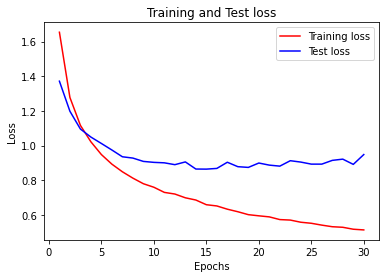

In [127]:
epochs = np.arange(1, epochs+1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Plot the Training/Test Accuracy

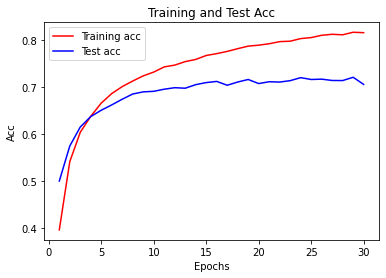

In [128]:
plt.clf()   # 그래프를 초기화합니다
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Test Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()